<a href="https://colab.research.google.com/github/adikeshn/Alzheimer-MRI-Classification/blob/main/Alzheimers_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading Libraries and the MRI image data

In [2]:
!pip install q kaggle


In [3]:
from google.colab import files
import pandas as pd
import numpy as np
from google.colab import autoviz
import seaborn as sns
import os
import random
import matplotlib.pylab as plt
from tensorflow.keras import datasets, layers, models
import tensorflow as tf

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adiknathan","key":"eb407008861e258b93fbe53baacea33a"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
! unzip /content/augmented-alzheimer-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: OriginalDataset/NonDemented/31 (10).jpg  
  inflating: OriginalDataset/NonDemented/31 (100).jpg  
  inflating: OriginalDataset/NonDemented/31 (11).jpg  
  inflating: OriginalDataset/NonDemented/31 (12).jpg  
  inflating: OriginalDataset/NonDemented/31 (13).jpg  
  inflating: OriginalDataset/NonDemented/31 (14).jpg  
  inflating: OriginalDataset/NonDemented/31 (15).jpg  
  inflating: OriginalDataset/NonDemented/31 (16).jpg  
  inflating: OriginalDataset/NonDemented/31 (17).jpg  
  inflating: OriginalDataset/NonDemented/31 (18).jpg  
  inflating: OriginalDataset/NonDemented/31 (19).jpg  
  inflating: OriginalDataset/NonDemented/31 (2).jpg  
  inflating: OriginalDataset/NonDemented/31 (20).jpg  
  inflating: OriginalDataset/NonDemented/31 (21).jpg  
  inflating: OriginalDataset/NonDemented/31 (22).jpg  
  inflating: OriginalDataset/NonDemented/31 (23).jpg  
  inflating: OriginalDataset/NonDemented/31 (24).jpg  
  inflating: O

# Data Preprocessing

Getting the images from each folder and putting them in an array


*   Same amount of images per classification in the array (prevents model bias toward one classification)
*   Setting the max-height and max-width variable for later use in image processing



In [7]:

classificationID = 0
images = []
labels = []
first = []
max_height = 0
max_width = 0

for folder in os.listdir("AugmentedAlzheimerDataset"):
  folder_path = os.path.join("AugmentedAlzheimerDataset", folder)
  num_images = 0
  for file in os.listdir(folder_path):
    image_path = os.path.join(folder_path, file)
    image = plt.imread(image_path)
    height, width, _ = image.shape
    max_height = max(max_height, height)
    max_width = max(max_width, width)
    first.append([image, classificationID])
    num_images += 1
    if num_images == 6400:
      break

  classificationID += 1

random.shuffle(first)

for data in first:
  images.append(data[0])
  labels.append([data[1]])




*   Compress: compresses each image passed into it by first adding padding to make each image to make all of them the same size, making the image grayscale to reduce unneccesary color information by averaging the RGB values and reducing the dimensions of the image array to 2, and making each value in the array be between 0-1
*   predict: predicts what classification an image belongs to using the model





In [98]:
def compress(image):
  resized_image = tf.image.resize_with_pad(image, max_height, max_width)
  grayscale_images = np.mean(resized_image, axis=2)
  normalized_image = np.array((grayscale_images - np.min(grayscale_images)) / (np.max(grayscale_images) - np.min(grayscale_images)))

  zero_filtered = np.where(normalized_image <= 0.033, 0, normalized_image)
  return zero_filtered

def predict(image, compressed):
  if not compressed:
    image = compress(image)
  predictions = model.predict(image.reshape(1, max_height, max_width, 1), verbose = 0)
  return np.argmax(predictions)

def Id_to_classification(id):
  if id == 0:
    return "MildDementia"
  elif id == 1:
    return "ModerateDementia"
  elif id == 2:
    return "NonDementia"
  elif id == 3:
    return "VeryMildDementia"



Compressing each image and adding them into a new array

In [9]:
compressed_images = []
for image in images:
  compressed_images.append(compress(image))


compressed_images = np.array(compressed_images)
labels = np.array(labels)


Splitting the dataset into training and testing

In [11]:
train_test_split_ratio = 0.9

num_data = labels.shape[0]
train_size = int(num_data * train_test_split_ratio)

train_images = zero_filtered[:train_size]
train_labels = labels[:train_size]
test_images = zero_filtered[train_size:]
test_labels = labels[train_size:]

train_images = train_images.reshape((train_images.shape[0], 190, 200, 1))
test_images = test_images.reshape((test_images.shape[0], 190, 200, 1))

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Creating the Model

I am using a CNN model to classify the images, with 3 CNN layers and 3 pooling layers, followed by a dense layer and a dropout to reduce overfitting

In [15]:

model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(190, 200, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=7,
                    validation_data=(test_images, test_labels))

# Testing the Model

True: NonDementia Predicted: MildDementia


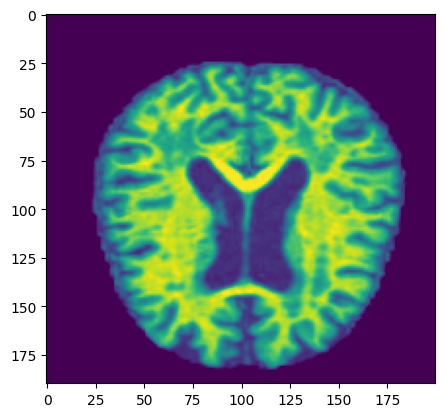

True: NonDementia Predicted: NonDementia


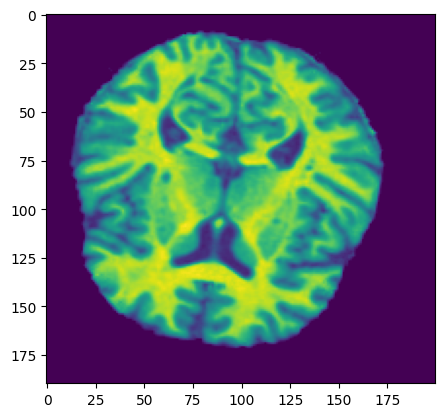

True: ModerateDementia Predicted: ModerateDementia


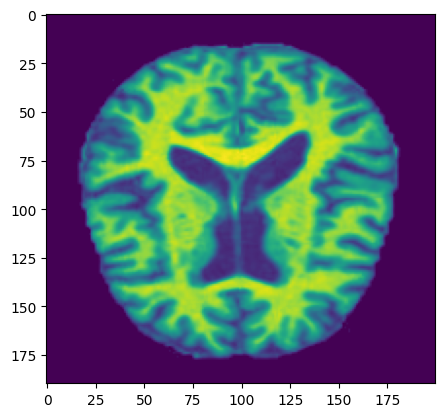

True: NonDementia Predicted: NonDementia


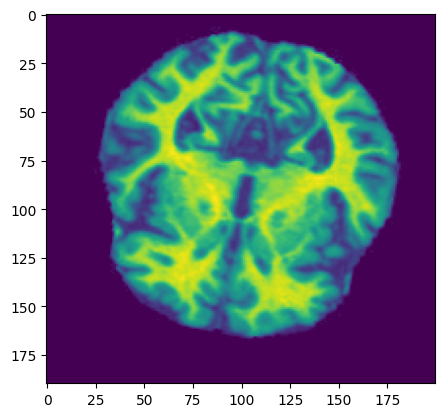

True: NonDementia Predicted: NonDementia


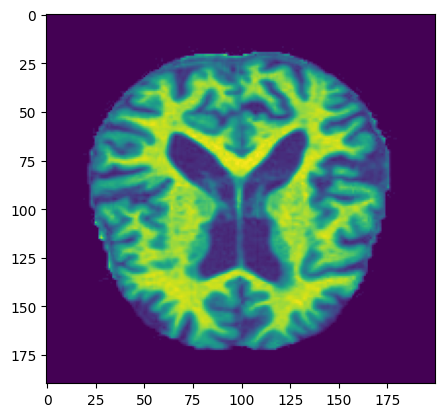

True: NonDementia Predicted: ModerateDementia


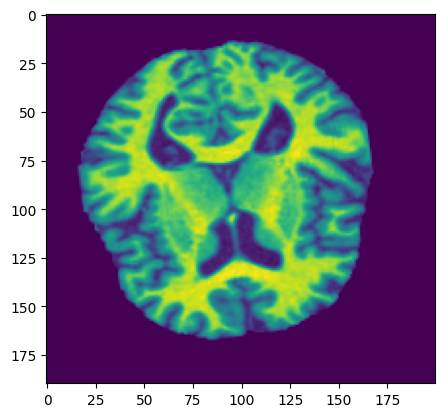

True: VeryMildDementia Predicted: VeryMildDementia


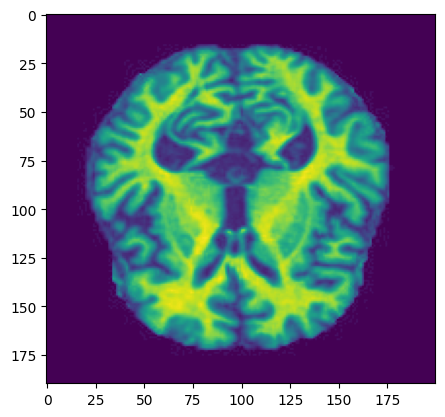

True: NonDementia Predicted: MildDementia


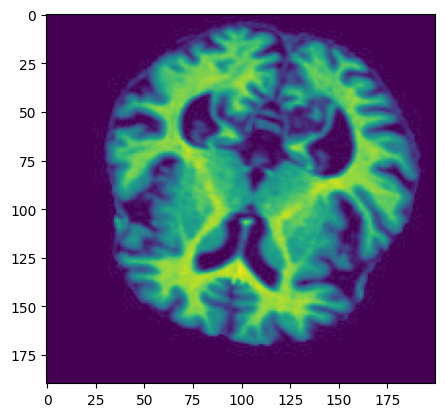

True: VeryMildDementia Predicted: VeryMildDementia


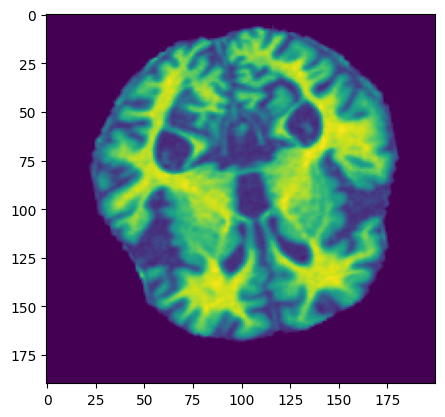

True: MildDementia Predicted: MildDementia


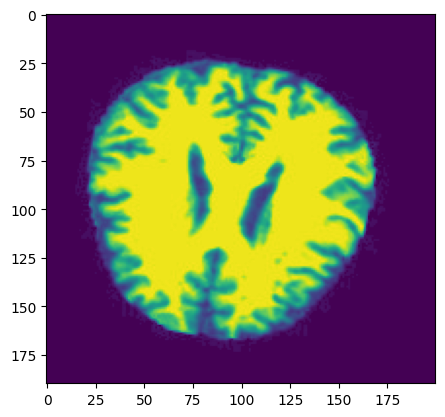

True: VeryMildDementia Predicted: VeryMildDementia


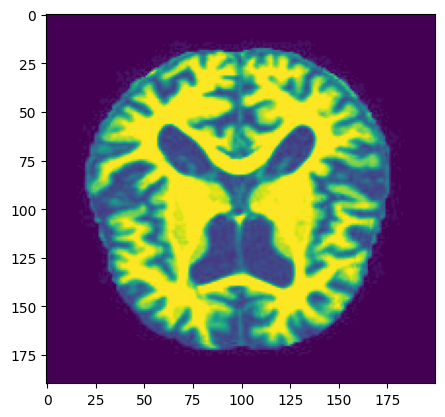

True: MildDementia Predicted: ModerateDementia


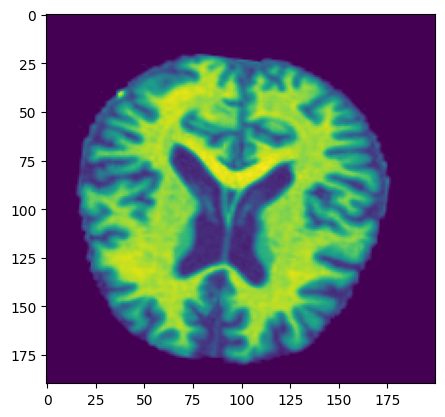

True: NonDementia Predicted: NonDementia


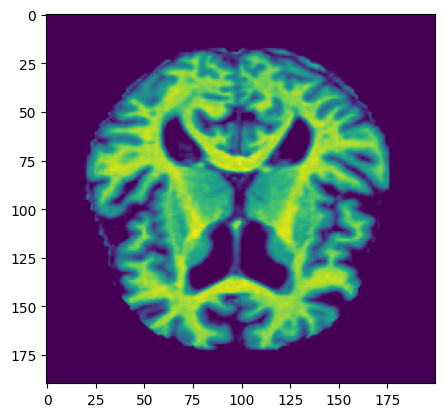

True: VeryMildDementia Predicted: VeryMildDementia


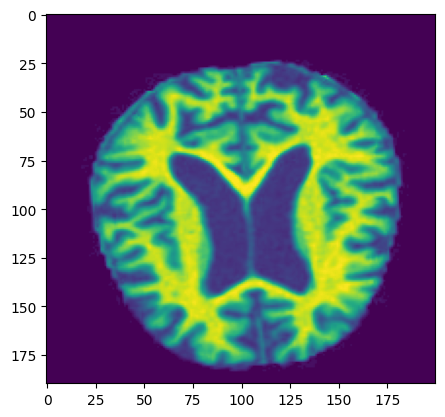

True: NonDementia Predicted: NonDementia


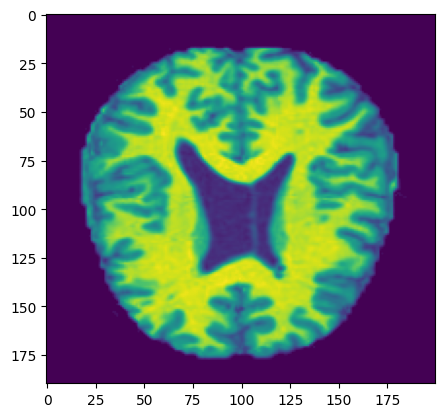

True: MildDementia Predicted: MildDementia


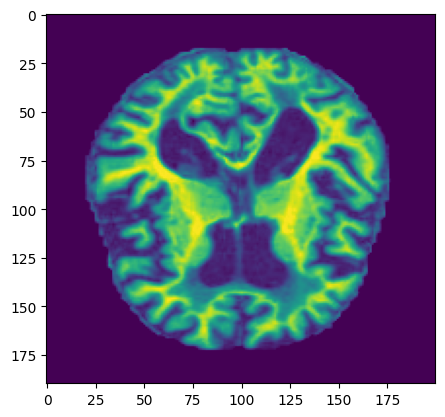

True: ModerateDementia Predicted: MildDementia


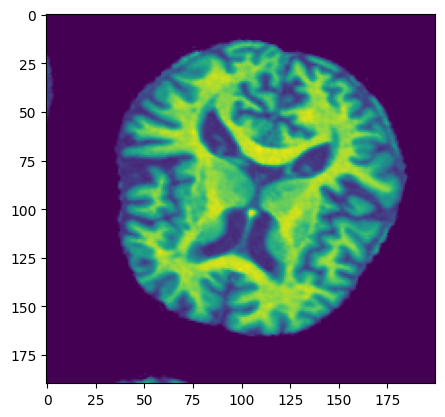

True: ModerateDementia Predicted: NonDementia


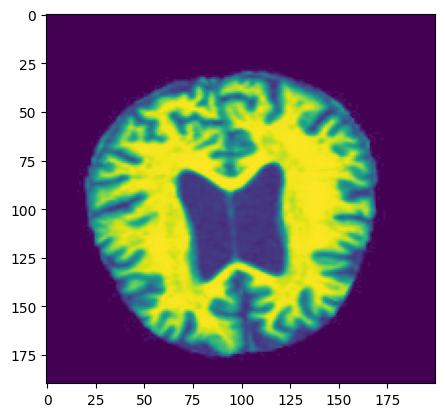

True: MildDementia Predicted: MildDementia


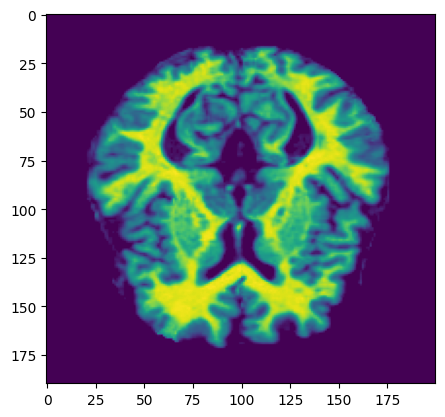

True: MildDementia Predicted: MildDementia


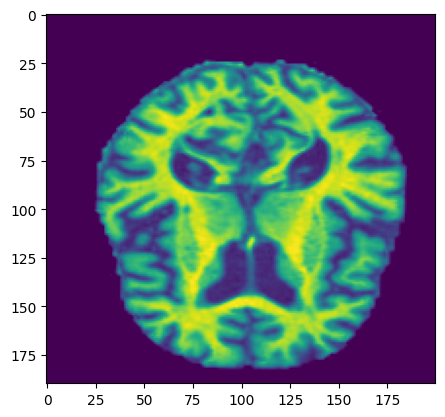

True: NonDementia Predicted: NonDementia


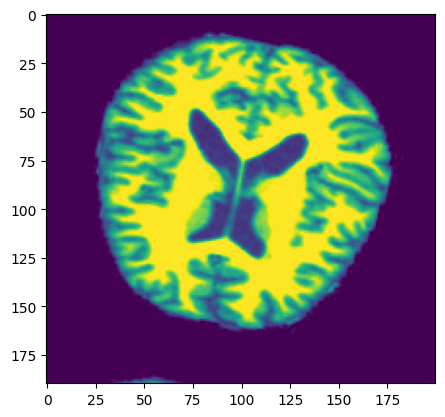

True: NonDementia Predicted: NonDementia


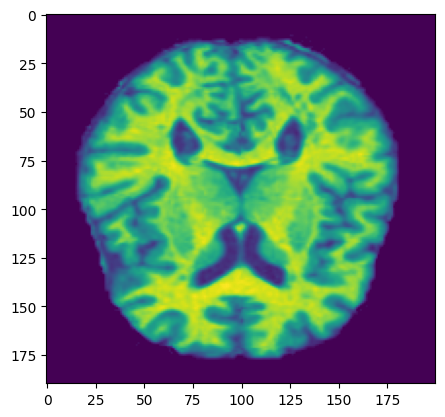

True: MildDementia Predicted: MildDementia


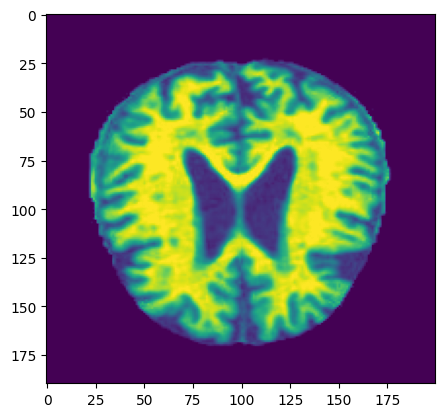

True: ModerateDementia Predicted: ModerateDementia


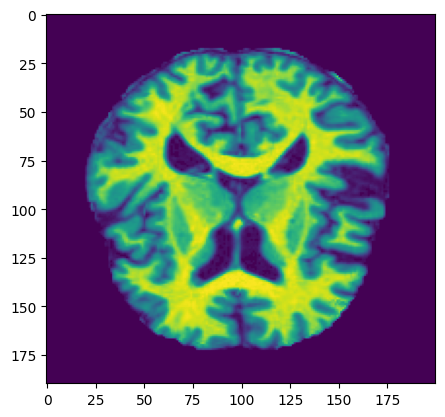

True: MildDementia Predicted: MildDementia


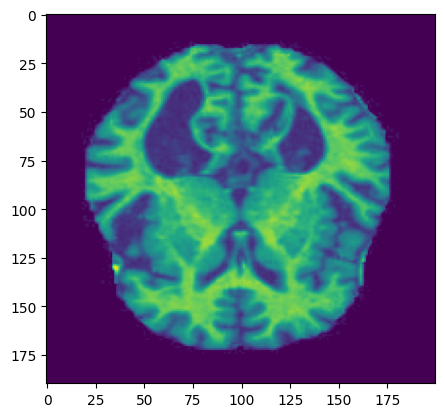

True: ModerateDementia Predicted: ModerateDementia


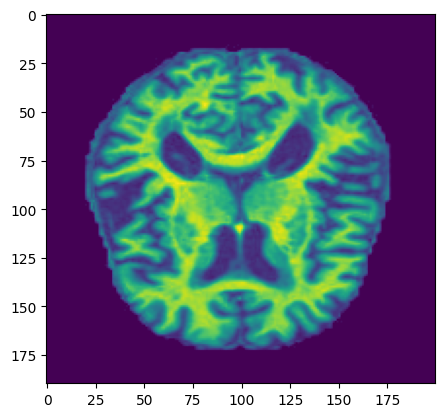

True: MildDementia Predicted: MildDementia


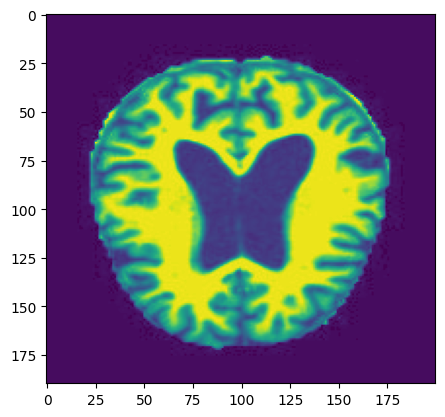

True: MildDementia Predicted: MildDementia


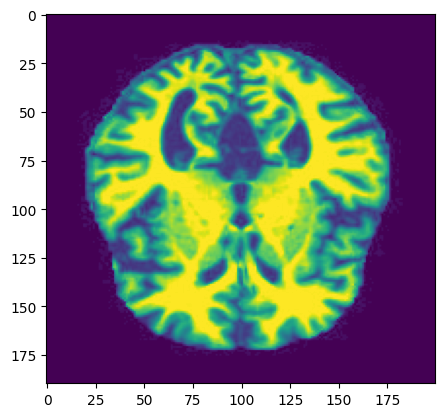

True: NonDementia Predicted: NonDementia


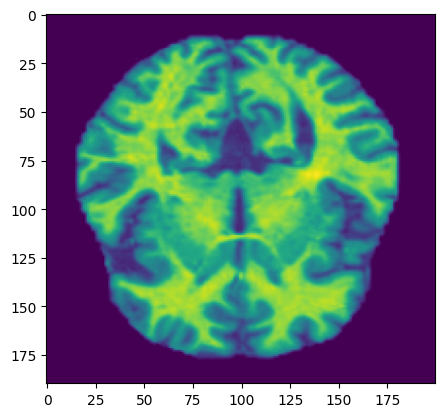

True: VeryMildDementia Predicted: VeryMildDementia


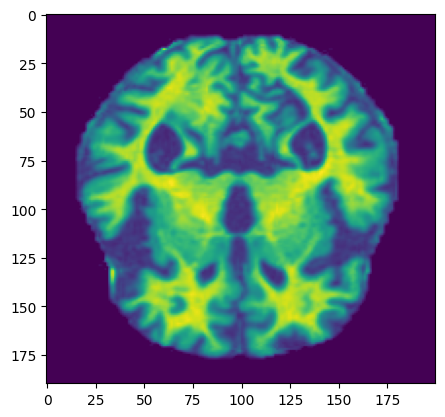

True: MildDementia Predicted: MildDementia


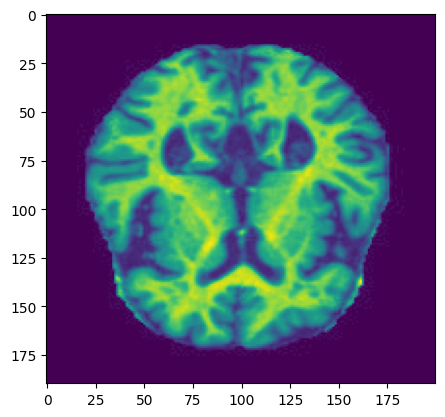

True: VeryMildDementia Predicted: VeryMildDementia


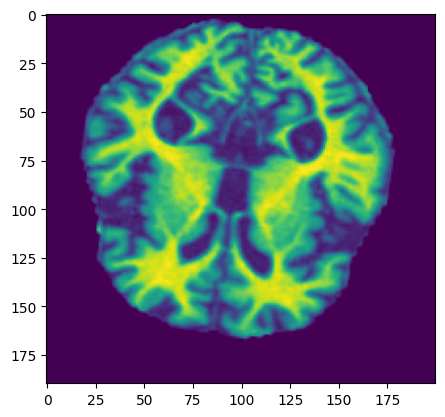

True: VeryMildDementia Predicted: VeryMildDementia


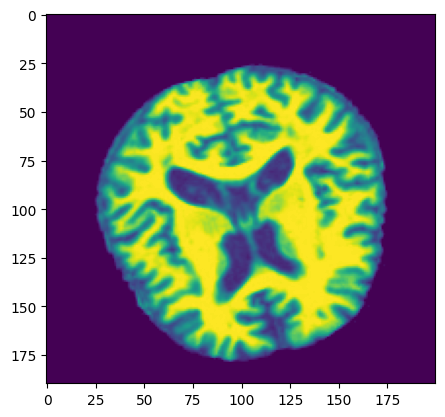

True: ModerateDementia Predicted: ModerateDementia


KeyboardInterrupt: 

In [103]:
for index in range(len(test_images)):
  print(f"True: {Id_to_classification(test_labels[index])} Predicted: {Id_to_classification(predict(test_images[index], True))}")
  plt.imshow(test_images[index].reshape(max_height, max_width))
  plt.show()
